In [1]:
%matplotlib inline

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint, uniform
from sklearn import linear_model, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestRegressor)
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import (classification_report, mean_absolute_error, r2_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   PolynomialFeatures, RobustScaler,
                                   StandardScaler)
from sklearn.svm import SVC

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [2]:
# import data
dataset_og = pd.read_csv('..\Data\Measurements-Transformed')
# kopie maken indien we iets van de originele data nodig hebben
dataset = dataset_og.copy()
dataset.head(5)

,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
0,686972,0,21118,0.0,-1.75,0.5,55.0,-2.25,1.0,55.0,-1.75,1.0,110.0,-1.25,0.5,110.0
1,686972,0,20245,0.0,-1.75,0.5,65.0,0.00,0.0,0.0,-1.25,0.5,110.0,0.00,0.0,0.0
2,686972,0,18099,0.0,-1.50,0.5,65.0,0.00,0.0,0.0,-1.00,0.5,110.0,0.00,0.0,0.0
3,803500,1,6845,0.0,-1.50,0.5,170.0,0.00,0.0,0.0,-1.50,0.5,170.0,0.00,0.0,0.0
4,803500,1,5779,0.0,-0.75,0.5,170.0,0.00,0.0,0.0,-1.00,0.5,170.0,0.00,0.0,0.0


### Features:
Sex: geslacht

Measurement_Age:

Add: additie, is altijd gelijk in beide ogen

Sph-Far-R: sphere ver van rechter oog, zowel + als - waardes

Cyl-Far-R: cylinder ver van rechter oog, zowel + als - waardes

Axis-Far-R: as ver van rechteroog, waarde tussen 0 en 180

Sph-Close-R: sphere dicht van rechteroog = som van add + Sph-Far-R, zowel + als - waardes

Cyl-Close-R: cylinder dicht van rechteroog, zowel + als - waardes

Axis-Close-R: as dicht van rechteroog, waarde tussen 0 en 180

Sph-Far-L: sphere ver van linker oog, zowel + als - waardes

Cyl-Far-L: cylinder ver van linker oog, zowel + als - waardes

Axis-Far-L: as ver van linker oog, tussen 0 en 180

Sph-Close-L: sphere dicht van linker oog = som van add + Sph-Far-L, zowel + als - waardes

Cyl-Close-L: cylinder dicht van linker oog, zowel + als - waardes

Axis-Close-L: as dicht van linker oog, tussen 0 en 180

In [3]:
#??????????????
for coll in dataset.columns:
    coll = np.nan_to_num(coll)
pd.DataFrame(dataset).fillna(0, inplace=True)
np.where(np.isnan(dataset))

(array([], dtype=int64), array([], dtype=int64))

In [4]:
#drop rijen waar < n meting van zijn en houd van de overige de top n meest recente waardes
n = 2
dataset = dataset.groupby('ID').filter(lambda x: len(x) > (n-1))
dataset = dataset.groupby('ID').head(n)

In [5]:
dataset.head(6)

,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
0,686972,0,21118,0.00,-1.75,0.50,55.0,-2.25,1.00,55.0,-1.75,1.00,110.0,-1.25,0.50,110.0
1,686972,0,20245,0.00,-1.75,0.50,65.0,0.00,0.00,0.0,-1.25,0.50,110.0,0.00,0.00,0.0
3,803500,1,6845,0.00,-1.50,0.50,170.0,0.00,0.00,0.0,-1.50,0.50,170.0,0.00,0.00,0.0
4,803500,1,5779,0.00,-0.75,0.50,170.0,0.00,0.00,0.0,-1.00,0.50,170.0,0.00,0.00,0.0
5,315625,1,20777,2.25,3.75,0.75,5.0,2.00,0.25,5.0,-1.25,0.25,135.0,0.50,0.75,135.0
6,315625,1,19033,2.25,-1.25,0.00,0.0,1.00,0.00,0.0,-1.50,0.00,0.0,0.75,0.00,0.0


In [6]:
#weglaten van de minst gecorreleerde features
# dataset.drop(['Sex', 'Add', 'Axis-Close-R', 'Axis-Close-L'],axis=1, inplace=True)

# #2 rijen naast elkaar zetten

# dataset = dataset.merge(dataset ,on=['ID'], suffixes=['_x', ''])
# dataset = dataset.sort_values(by=['ID', 'Measurement_Age_x'])
# dataset = dataset.drop_duplicates(subset=['ID'], keep='first')
# dataset.head()

In [7]:
#2 rijen naast elkaar zetten

dataset = dataset.merge(dataset ,on=['ID', 'Sex'], suffixes=['_x', ''])
dataset = dataset.sort_values(by=['ID', 'Measurement_Age_x'])
dataset = dataset.drop_duplicates(subset=['ID', 'Sex'], keep='first')
dataset.head()

,ID,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
24834,100156,1,16642,0.00,0.00,0.00,0.0,1.00,0.25,90.0,0.0,0.0,0.0,1.00,0.25,90.0,16694,0.0,-0.25,0.25,90.0,-0.25,0.25,90.0,-0.25,0.25,90.0,-0.25,0.25,90.0
838,100196,1,17665,1.75,-3.50,0.00,0.0,-1.75,0.00,0.0,-3.0,0.0,0.0,-1.25,0.00,0.0,21420,0.0,-3.50,0.00,0.0,-3.50,0.00,0.0,-3.00,0.00,0.0,-3.00,0.00,0.0
4838,100203,1,5020,0.00,-1.75,0.00,0.0,0.00,0.00,0.0,-2.0,0.5,55.0,0.00,0.00,0.0,6007,0.0,-2.00,0.00,0.0,-2.00,0.00,0.0,-2.25,0.50,75.0,-2.25,0.50,75.0
11378,100221,0,25706,0.00,1.50,0.75,90.0,-1.00,1.00,90.0,1.0,1.0,90.0,-0.75,0.75,90.0,25728,2.5,1.75,0.75,90.0,4.00,1.00,90.0,1.50,1.00,90.0,4.25,0.75,90.0
27502,100414,1,15557,0.00,-0.50,0.00,0.0,0.00,0.00,0.0,-0.5,0.0,0.0,0.00,0.00,0.0,15723,0.0,-0.50,0.00,0.0,-0.50,0.00,0.0,-0.50,0.00,0.0,-0.50,0.00,0.0


In [8]:
#Drop kolom ID
dataset.drop(['ID'],axis=1, inplace=True)


### Linear regression

In [9]:
# Splitsen in features en targets

y = dataset['Sph-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_sph_far_r = linear_model.LinearRegression()
lreg_sph_far_r.fit(X_train,y_train)
print(lreg_sph_far_r.coef_)
r2 = lreg_sph_far_r.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_sph_far_r = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_sph_far_r.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_sph_far_r.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_sph_far_r.score(X_train_poly,y_train))


# # met L1 regularisatie via Lasso regression
# lreg_poly_sph_far_r = Lasso(alpha=0.001,tol=0.0001,fit_intercept=True)
# lreg_poly_sph_far_r.fit(X_train_poly,y_train)      
  
      
# print('R2 score op test set via L1: ',lreg_poly_sph_far_r.score(X_test_poly,y_test))
  
# # R2 -score via L1 op de trainingset
# print('R2 score op training set via L1: ',lreg_poly_sph_far_r.score(X_train_poly,y_train))    

# # Variëren van de alpha en grafiek

# train_r2 = []
# test_r2 = []


# alphas = np.logspace(-2, 6, 1000)

# for alpha in alphas:
#     lregmodel_poly = Ridge(alpha=alpha,tol=0.0001,fit_intercept=True)
#     lregmodel_poly.fit(X_train_poly,y_train)
#     test_r2.append(lregmodel_poly.score(X_test_poly,y_test))  
#     train_r2.append(lregmodel_poly.score(X_train_poly,y_train))


# # Plot r2
# f, ax = plt.subplots(figsize=(10, 8))
# plt.subplot(2, 1, 1)
# plt.semilogx(alphas, train_r2, label='Train')
# plt.semilogx(alphas, test_r2, label='Test')
# plt.legend(loc='lower left')
# plt.ylim([0, 1.2])
# plt.xlabel('Regularization parameter')
# plt.ylabel('R² Performance')



# Via KernelRidge met een polynomial kernel

# from sklearn.kernel_ridge import KernelRidge

# lreg_sph_far_r = KernelRidge(alpha=0.001, degree=3, gamma=None, kernel='polynomial')
# lreg_sph_far_r.fit(X_train,y_train)


# y_predicted = lreg_sph_far_r.predict(X_train)
# r2 = r2_score(y_train,y_predicted)

# print('training set: ',r2)

# y_predicted = lreg_sph_far_r.predict(X_test)
# r2 = r2_score(y_test,y_predicted)

# print('test set: ',r2)

[ 0.01042548 -0.23958148 -0.17247075  1.91871708  0.06558181 -0.08473874
  0.1201923  -0.06568443  0.08126178  0.42249269  0.00811944 -0.05788306
  0.08573375  0.01296807  0.05848437  0.60915764]
r2 score =  0.7926300037801015
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.8026277411912672
R2 score op training set via L2:  0.823370148590846


In [10]:
# Splitsen in features en targets

y = dataset['Cyl-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_cyl_far_r = linear_model.LinearRegression()
lreg_cyl_far_r.fit(X_train,y_train)
print(lreg_cyl_far_r.coef_)
r2 = lreg_cyl_far_r.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_cyl_far_r = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_cyl_far_r.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_cyl_far_r.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_cyl_far_r.score(X_train_poly,y_train))

[ 3.36376909e-03 -1.88834066e-01 -3.02852799e-02 -1.45148945e-02
  2.85918781e-01 -2.55229953e-02  1.49599931e-02  6.06743440e-02
  2.01781672e-02 -1.98411541e-04  4.11921013e-02 -1.47106212e-02
  1.10190239e-02 -7.86034792e-03  5.60859213e-03  1.80853490e-01]
r2 score =  0.546780581747505
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.5672105530557865
R2 score op training set via L2:  0.6347515515920231


In [11]:
# Splitsen in features en targets

y = dataset['Sph-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_sph_far_l = linear_model.LinearRegression()
lreg_sph_far_l.fit(X_train,y_train)
print(lreg_sph_far_l.coef_)
r2 = lreg_sph_far_l.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_sph_far_l = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_sph_far_l.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_sph_far_l.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_sph_far_l.score(X_train_poly,y_train))

[ 0.00764919 -0.3333425  -0.16859439  0.37302679  0.03377242 -0.10378072
 -0.05865916  0.00486961  0.07442712  1.9817605   0.01928813 -0.02876889
  0.24267037 -0.04615268  0.05452169  0.70527669]
r2 score =  0.7946932417452822
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.8020691884954725
R2 score op training set via L2:  0.8170510550074199


In [12]:
# Splitsen in features en targets

y = dataset['Cyl-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_cyl_far_l = linear_model.LinearRegression()
lreg_cyl_far_l.fit(X_train,y_train)
print(lreg_cyl_far_l.coef_)
r2 = lreg_cyl_far_l.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_cyl_far_l = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_cyl_far_l.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_cyl_far_l.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_cyl_far_l.score(X_train_poly,y_train))

[ 0.00062715 -0.18843641 -0.03283339 -0.00248423  0.0367938   0.00584703
  0.00884841 -0.01292222  0.003611   -0.01212008  0.28071655 -0.02785209
  0.02064122  0.0659568   0.01359659  0.18993009]
r2 score =  0.5835945502641658
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.5917345391264747
R2 score op training set via L2:  0.6387595495919842


### Random forest regressor

In [13]:
# Splitsen in features en targets

y = dataset['Sph-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#random forest regressor
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFR_model_sph_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_sph_far_r.fit(X_train,y_train)

RFR_model_sph_far_r.score(X_test,y_test)

0.8157831829392315

In [14]:
#feature importance
# top 10 meest belangrijke features
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFRmodel_reduced_sph_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)

importance = RFR_model_sph_far_r.feature_importances_

print(importance)

# index van de 10 belangrijkste features:

ind = np.argpartition(importance,-16)[-16:]

print(ind)

X_train_reduced = X_train.iloc[:,ind]
X_test_reduced = X_test.iloc[:,ind]

# print top 10 features.
feature_values = RFR_model_sph_far_r.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

# hertrainen van Random Forest Tree Classifier

RFRmodel_reduced_sph_far_r.fit(X_train_reduced,y_train)

y_pred_reduced = RFRmodel_reduced_sph_far_r.predict(X_test_reduced)

#print(R2)
print("R2:", RFRmodel_reduced_sph_far_r.score(X_test,y_test)) 

[0.00133031 0.03429937 0.00334249 0.4970822  0.00380634 0.00449841
 0.08522986 0.00137714 0.00228514 0.27548947 0.0033954  0.00523949
 0.04931097 0.00124865 0.00173732 0.03032744]
[13  1  2  3  4  5  6  7  8  9 10 11 12  0 14 15]
10 Belangrijkste features:
3           Sph-Far-R_x
9           Sph-Far-L_x
6         Sph-Close-R_x
12        Sph-Close-L_x
1     Measurement_Age_x
15      Measurement_Age
11         Axis-Far-L_x
5          Axis-Far-R_x
4           Cyl-Far-R_x
10          Cyl-Far-L_x
Name: names, dtype: object
R2: 0.8159677085743532


In [15]:
# Splitsen in features en targets

y = dataset['Cyl-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#random forest regressor
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFR_model_cyl_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_cyl_far_r.fit(X_train,y_train)

RFR_model_cyl_far_r.score(X_test,y_test)

0.5756887732636975

In [16]:
#feature importance
# top 10 meest belangrijke features
number_of_trees = 200
max_number_of_depth = 20
max_number_of_features = 0.5

RFRmodel_reduced_cyl_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)

importance = RFR_model_cyl_far_r.feature_importances_

print(importance)

# index van de 10 belangrijkste features:

ind = np.argpartition(importance,-16)[-16:]

print(ind)

X_train_reduced = X_train.iloc[:,ind]
X_test_reduced = X_test.iloc[:,ind]

# print top 10 features.
feature_values = RFR_model_cyl_far_r.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

# hertrainen van Random Forest Tree Classifier

RFRmodel_reduced_cyl_far_r.fit(X_train_reduced,y_train)

y_pred_reduced = RFRmodel_reduced_cyl_far_r.predict(X_test_reduced)

#print(R2)
print("R2:", RFRmodel_reduced_cyl_far_r.score(X_test,y_test)) 

[0.00375471 0.03230078 0.00563724 0.01857238 0.44648298 0.1653248
 0.01211405 0.06039857 0.02455614 0.02018976 0.07464015 0.0414829
 0.01180476 0.03139843 0.0122983  0.03904406]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
10 Belangrijkste features:
4           Cyl-Far-R_x
5          Axis-Far-R_x
10          Cyl-Far-L_x
7         Cyl-Close-R_x
11         Axis-Far-L_x
15      Measurement_Age
1     Measurement_Age_x
13        Cyl-Close-L_x
8        Axis-Close-R_x
9           Sph-Far-L_x
Name: names, dtype: object
R2: 0.5687893070476606


In [17]:
# Splitsen in features en targets

y = dataset['Sph-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#random forest regressor
number_of_trees = 200
max_number_of_depth = 20
max_number_of_features = 6

RFR_model_sph_far_l = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_sph_far_l.fit(X_train,y_train)

RFR_model_sph_far_l.score(X_test,y_test)

0.8137267633414702

In [18]:
# print top 10 features.
feature_values = RFR_model_sph_far_l.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

10 Belangrijkste features:
9           Sph-Far-L_x
3           Sph-Far-R_x
12        Sph-Close-L_x
1     Measurement_Age_x
15      Measurement_Age
6         Sph-Close-R_x
11         Axis-Far-L_x
5          Axis-Far-R_x
10          Cyl-Far-L_x
4           Cyl-Far-R_x
Name: names, dtype: object


In [19]:
# Splitsen in features en targets

y = dataset['Cyl-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#random forest regressor
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFR_model_cyl_far_l = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_cyl_far_l.fit(X_train,y_train)

RFR_model_cyl_far_l.score(X_test,y_test)

0.5930567826447974

In [20]:
# print top 10 features.
feature_values = RFR_model_cyl_far_l.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

10 Belangrijkste features:
10          Cyl-Far-L_x
11         Axis-Far-L_x
4           Cyl-Far-R_x
13        Cyl-Close-L_x
5          Axis-Far-R_x
15      Measurement_Age
1     Measurement_Age_x
7         Cyl-Close-R_x
14       Axis-Close-L_x
9           Sph-Far-L_x
Name: names, dtype: object


In [21]:
print(dataset.shape)
dataset.head(10)

(8542, 29)


,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
24834,1,16642,0.00,0.00,0.00,0.0,1.00,0.25,90.0,0.00,0.00,0.0,1.00,0.25,90.0,16694,0.0,-0.25,0.25,90.0,-0.25,0.25,90.0,-0.25,0.25,90.0,-0.25,0.25,90.0
838,1,17665,1.75,-3.50,0.00,0.0,-1.75,0.00,0.0,-3.00,0.00,0.0,-1.25,0.00,0.0,21420,0.0,-3.50,0.00,0.0,-3.50,0.00,0.0,-3.00,0.00,0.0,-3.00,0.00,0.0
4838,1,5020,0.00,-1.75,0.00,0.0,0.00,0.00,0.0,-2.00,0.50,55.0,0.00,0.00,0.0,6007,0.0,-2.00,0.00,0.0,-2.00,0.00,0.0,-2.25,0.50,75.0,-2.25,0.50,75.0
11378,0,25706,0.00,1.50,0.75,90.0,-1.00,1.00,90.0,1.00,1.00,90.0,-0.75,0.75,90.0,25728,2.5,1.75,0.75,90.0,4.00,1.00,90.0,1.50,1.00,90.0,4.25,0.75,90.0
27502,1,15557,0.00,-0.50,0.00,0.0,0.00,0.00,0.0,-0.50,0.00,0.0,0.00,0.00,0.0,15723,0.0,-0.50,0.00,0.0,-0.50,0.00,0.0,-0.50,0.00,0.0,-0.50,0.00,0.0
4178,1,8568,0.00,-1.25,0.00,0.0,0.00,0.00,0.0,-1.75,0.00,0.0,0.00,0.00,0.0,9504,0.0,-1.75,0.25,75.0,-1.75,0.25,75.0,-2.00,0.25,85.0,-2.00,0.25,85.0
29590,1,10887,0.00,-1.00,0.75,70.0,0.00,0.00,0.0,-1.25,1.00,105.0,0.00,0.00,0.0,11354,0.0,-1.25,1.25,70.0,-1.25,1.25,70.0,-1.50,1.50,105.0,-1.50,1.50,105.0
20960,1,29173,0.00,0.00,1.50,160.0,0.00,1.50,160.0,0.50,0.75,0.0,0.50,0.75,0.0,29173,0.0,0.00,1.50,160.0,0.00,1.50,160.0,0.50,0.75,0.0,0.50,0.75,0.0
1442,1,15392,0.00,-2.00,0.75,145.0,0.00,0.00,0.0,-2.25,0.75,65.0,0.00,0.00,0.0,16799,1.5,-1.75,0.75,160.0,-0.25,0.75,160.0,-1.75,0.75,60.0,-0.25,0.75,60.0
28500,1,16071,0.00,-0.25,0.50,150.0,-0.25,0.50,150.0,-0.25,0.75,80.0,-0.25,0.75,80.0,16071,0.0,-0.25,0.50,150.0,-0.25,0.50,150.0,-0.25,0.75,80.0,-0.25,0.75,80.0


In [22]:
values = dataset_og.loc[[1146]]
values.drop(['ID'], axis=1, inplace=True)
age = values.iat[0,1]
years = 5
print(age)
values.head()

23521


,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
1146,1,23521,2.75,3.5,0.75,60.0,6.5,0.5,60.0,1.25,0.5,125.0,3.75,0.75,125.0


In [23]:
values = np.array([[1.0,18358.0,0.0,-1.00,0.5,175.0,0.0,0.00,0.0,-1.50,1.25,165.0,0.00,0.0,0.0,20686.0]])


#Sph-Far-R = -1
#Cyl-Far-R = 0.25
#Sph-Far-L = -1.50
#Cyl-Far-L = 1.25

# values = values.reshape(-1, 1)
# scaler1.fit(values)
# values = scaler1.transform(values)

models = [lreg_sph_far_r, lreg_cyl_far_r, lreg_sph_far_l, lreg_cyl_far_l,
          RFR_model_sph_far_r, RFR_model_cyl_far_r, RFR_model_sph_far_l, RFR_model_cyl_far_l,RFRmodel_reduced_sph_far_r,RFRmodel_reduced_cyl_far_r]

for n in models:
    x = n.predict(values)
#     a = np.array([0, 0, 0, x, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#     x = scaler1.inverse_transform(x)
    print(x)


[8175.80172574]
[268.14304511]
[8443.51192741]
[466.69708886]
[-0.44228914]
[0.40939392]
[-1.15635708]
[0.99070541]
[-0.45798887]
[0.33625]


[3.272932617403596, 3.2823644355854147, 3.2732886210490735, 3.290567571265524, 3.276692571265524, 3.252531387054998, 3.2397536092772197, 3.216411595388331, 3.205161595388331, 3.1800782620549986]


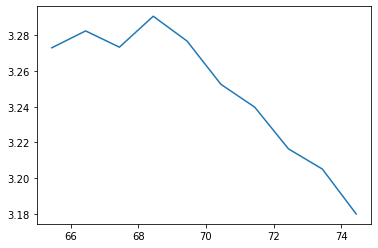

In [27]:
values = dataset_og.loc[[1146]]
values.drop(['ID'], axis=1, inplace=True)
age = values.iat[0,1]
years = 10
pred= []
ages = []

values = values.assign(Measurement_Age_x=[age])
values.head()

for x in range(0,years):
    values['Measurement_Age_x'] = values['Measurement_Age_x'].add(365)
    age2 = values.iat[0,-1]
    x = RFR_model_sph_far_r.predict(values)
    ages.append(age2)
    pred.append(x[0])
        
print(pred)
ages = [x / 365 for x in ages]
plt.plot(ages, pred)

In [25]:
X_train.head()

,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age
30,0,18207,1.50,0.75,0.00,0.0,2.25,0.0,0.0,0.00,0.0,0.0,1.50,0.0,0.0,18905
11146,1,6049,0.00,-0.25,0.25,90.0,0.00,0.0,0.0,-0.25,0.0,0.0,0.00,0.0,0.0,6736
8814,0,18657,0.00,0.00,0.00,0.0,2.00,0.0,45.0,0.00,0.0,0.0,1.50,0.5,90.0,21014
11242,1,17942,1.25,2.00,0.00,0.0,3.25,0.0,0.0,1.50,0.0,0.0,2.75,0.0,0.0,18979
28762,0,11174,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,16932
